In [301]:
from IPython.display import clear_output as clear
import warnings
warnings.filterwarnings('ignore')

In [302]:
!pip install --upgrade --quiet gigachain==0.2.6 gigachain_community==0.2.6 gigachain-cli==0.0.25 duckduckgo-search==6.2.4 pyfiglet==1.0.2 langchain-anthropic python-dotenv
clear()

In [303]:
from dotenv import load_dotenv
load_dotenv('env.txt')

True

In [304]:
import os
import pandas as pd
import numpy as np
import requests
import time
from copy import deepcopy
import json
import re

from scipy.spatial.distance import cosine

import torch
from transformers import AutoTokenizer, AutoModel

from langchain.schema import HumanMessage, SystemMessage, AIMessage, LLMResult
from langchain.llms import HuggingFaceHub

from langchain.chat_models.gigachat import GigaChat
from langchain_core.language_models.chat_models import BaseChatModel
from pydantic import Field

from IPython.display import clear_output as clear
import warnings
warnings.filterwarnings('ignore')

In [305]:
os.environ['HF_API_TOKEN'] = os.getenv('HF_API_TOKEN')
os.environ['GIGACHAT_CREDENTIALS'] = os.getenv('GIGACHAT_CREDENTIALS')
os.environ['AI_TUNNEL_API'] = os.getenv('AI_TUNNEL_API')

os.environ['GPT_TUNNEL_API'] = os.getenv('GPT_TUNNEL_API')
ai_key = os.environ.get("GPT_TUNNEL_API")

# Test main pipeline

In [306]:
df = pd.read_parquet('/content/drive/MyDrive/HACKS/РЖД 12.10.2024/main_df.parquet')
ei = pd.read_parquet('/content/drive/MyDrive/HACKS/РЖД 12.10.2024/ed_izm.parquet')

df.reset_index(inplace=True)
df['index'] = df['index'].astype(str)

In [307]:
replace_dict = {
    'A': 'А', 'B': 'В',
    'E': 'Е', 'K': 'К', 'M': 'М',
    'H': 'Н', 'O': 'О', 'P': 'Р',
    'C': 'С', 'T': 'Т',  'X': 'Х',
}
def replace_eng_to_rus(text):
    original_text = text
    replacement_made = False
    for eng, rus in replace_dict.items():
        if eng in text:
            text = text.replace(eng, rus)
            replacement_made = True
    if replacement_made:
        print(f"Заменены английские буквы в строке: '{original_text}' на '{text}'")
    return text

ei['Краткое'] = ei['Краткое'].apply(replace_eng_to_rus)

Заменены английские буквы в строке: 'KT' на 'КТ'
Заменены английские буквы в строке: 'M3/C' на 'М3/С'
Заменены английские буквы в строке: 'M3/Ч' на 'М3/Ч'
Заменены английские буквы в строке: 'MKИ' на 'МКИ'
Заменены английские буквы в строке: 'C' на 'С'
Заменены английские буквы в строке: 'Т ПAР/Ч' на 'Т ПАР/Ч'
Заменены английские буквы в строке: 'T' на 'Т'


In [308]:
# ------ВАЖНО!------------------------------------------------------------------------
# если прогонять руками - в okpd_list будут все окпд2, по которым будем ходить в llm
# ------------------------------------------------------------------------------------


df_top_okpd = df.okpd.value_counts().to_frame()

# df_top_okpd = df_top_okpd[df_top_okpd['count'] <= 10000]
okpd_list = df_top_okpd.iloc[10:11].index.to_list() # <--------#####---------#####---------#####------ лист с окпд группами
okpd_names = df[df.okpd.isin(okpd_list)].drop_duplicates(subset='okpd').set_index('okpd').to_dict()['OKPD2_NAME']

# df_top_okpd[df_top_okpd['count'] > 10].head(50)#.sum()

In [473]:
# ------------------------------------------------------------------------------------
# для парсера нужны только заполненные параметры, пустые не рассматриваем
# ------------------------------------------------------------------------------------
df = df[~df.params.isna()]


# идея подобного разбиения заключается в однородности признаков бОльших групп
# нас интересуют группы по окпд поменьше, там больше хаоса
# поэтому решили изменить распределение
df_top_okpd.loc[df_top_okpd['count'] > 5000, 'sample_shape'] = (df_top_okpd['count'] * 0.1).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 3500) & (df_top_okpd['count'] <= 5000), 'sample_shape'] = (df_top_okpd['count'] * 0.2).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 2000) & (df_top_okpd['count'] <= 3500), 'sample_shape'] = (df_top_okpd['count'] * 0.3).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 1000) & (df_top_okpd['count'] <= 2000), 'sample_shape'] = (df_top_okpd['count'] * 0.35).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 700) & (df_top_okpd['count'] <= 1000), 'sample_shape'] = (df_top_okpd['count'] * 0.4).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 400) & (df_top_okpd['count'] <= 700), 'sample_shape'] = (df_top_okpd['count'] * 0.45).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 200) & (df_top_okpd['count'] <= 400), 'sample_shape'] = (df_top_okpd['count'] * 0.7).astype(int)
df_top_okpd.loc[(df_top_okpd['count'] > 100) & (df_top_okpd['count'] <= 200), 'sample_shape'] = (df_top_okpd['count'] * 0.8).astype(int)
# df_top_okpd.loc[df_top_okpd['count'] <= 100, 'sample_shape'] = df_top_okpd['count'].astype(int)
df_top_okpd = df_top_okpd[~df_top_okpd.sample_shape.isna()]
df_top_okpd.sample_shape = df_top_okpd.sample_shape.astype(int)
df_top_okpd.sample_shape.sum()


#нужно разбить это все на разные паркетники, чтобы параллельно в 10 ноутбуков запускать :D
df_main = pd.DataFrame()
for i, shape in enumerate(df_top_okpd.sample_shape):
  tmp_df = df[df.okpd == df_top_okpd.index[i]].sample(shape)
  df_main = pd.concat([df_main, tmp_df])

df_main.to_parquet('/content/drive/MyDrive/HACKS/РЖД 12.10.2024/main_df_sample.parquet')


for i in range(10):
  df_save = df_main.iloc[i*16000:(i+1)*16000]
  df_save.to_parquet(f'/content/drive/MyDrive/HACKS/РЖД 12.10.2024/main_df_sample_{i}.parquet')

In [310]:
def get_answer(prompt, system_prompt, model="gpt-4o-mini"):
  url = "https://gptunnel.ru/v1/chat/completions"
  headers = {
      "Authorization": f"Bearer {ai_key}",
      "Content-Type": "application/json"
  }
  data = {
      "model": model,
      "messages": [
          {
              "role": "system",
              "content": system_prompt
          },
          {
              "role": "user",
              "content": prompt
          }
      ]
  }
  response = requests.post(url, headers=headers, data=json.dumps(data))
  return response.json()


# ------------------------------------------------------------------------------------
# получаем примеры от gpt-4o для реализации few-shot промпта
# ------------------------------------------------------------------------------------
samples = {name: [] for name in okpd_list}
samples_id = {name: [] for name in okpd_list}

for i, items in enumerate(samples.items()):
  key, value = items
  print(i, key)
  tmp = df[df.okpd == key].sample(4)[['id', 'name', 'params']]

  for j in range(4):
    product_name = tmp['name'].iloc[j]
    product_params = tmp['params'].iloc[j]

    system_prompt = "Ты должен максимально корректно и локанично находить имена для характеристик, маскимально обобщая их названия"
    prompt = f"""
Тебе нужно разделить каждую характеристику продукта в формате JSON, ничего лишнего
Каждый продукт обладает своими характеристиками. Описание продукта не требуется.
Характеристики могут быть описаны буквально или через "=", например D=42, это обозначение диаметра 42мм

Пример вывода ответа
{{
    'Характеристика 1': 'Значение характеристики 1',
    'Характеристика 2': 'Значение характеристики 2',
    'Характеристика 3': 'Значение характеристики 3'
}}

Определи название характеристик:
Продукт - {product_name}
Характеристики: {product_params}
    """
    completion = get_answer(
        prompt=prompt,
        # client=client,
        model='gpt-4o',
        system_prompt=system_prompt
    ) #.choices[0].message.content

    samples[key].append(completion)
    samples_id[key].append(tmp['id'].iloc[j])

0 30.20.40.111


In [311]:
# ------------------------------------------------------------------------------------
# преобразование ответа llm в читаемый формат JSON
# ------------------------------------------------------------------------------------

wanna_cry = {key: [value['choices'][0]['message']['content'] for value in values] for key, values in samples.items()}

examples = {}
for key in wanna_cry.keys():
    result_list = []
    for data in wanna_cry[key]:
        jsn = data.replace('json', '').replace('```', '').replace("'", '"').replace('/n', '')
        jsn = json.loads(jsn)
        result_list.append(jsn)
    examples[key] = result_list

# для реализации промпта
ids = ['1', '30', '59385', '3993']
for i in range(4):
  examples[key][i] = {'Параметры': examples[key][i]}
  examples[key][i]['id'] = ids[i]

In [312]:
# ------------------------------------------------------------------------------------
# получаем okpd текущей группы, он находится в переменной key, будем работать в запросе ниже по нему
# ------------------------------------------------------------------------------------

key = df_top_okpd.reset_index()['okpd'].iloc[14]
total_parsed_params = [] # сюда записываем все обработанные ответы

In [317]:
# ------------------------------------------------------------------------------------
# создаем few-shot промпт, в котором настоятельно просим следовать определенной структуре ответа
# ------------------------------------------------------------------------------------

# проверяем работу LLM на рандомных подвыборках - используем "sample"
tmp_ = df[df.okpd == key].sample(10)[['index', 'params']]
params_to_llm = ('ID: ' + tmp_['index'].str[:] + '. Параметры:' + tmp_['params'].str[:]).to_list()
params_to_llm = '\n'.join(params_to_llm)

okpd_name = okpd_names[key]

system_prompt = """
Ты должен максимально корректно и локанично находить имена для характеристик, маскимально обобщая их названия
Формат вывода: {{'id': "заданный id", Параметры: {'Характеристика 1': 'Значение 1', 'Характеристика 2': 'Значение 2', ...}}, {...}}
"""
prompt = f'''
Тебе нужно разделить каждую характеристику продукта в формате JSON (словарь python), ничего лишнего.
Все продукты относятся к классу продуктов "{okpd_name}"
Каждый продукт обладает своими характеристиками. Описание продукта не требуется
Для каждого продукта необходимо занести в параметры его id

Пример 1:
ID: 1. Параметры: {df.loc[df.id == samples_id[key][0], 'params'].iloc[0]}
Ответ:
{examples[key][0]}

Пример 2:
ID: 30. Параметры: {df.loc[df.id == samples_id[key][1], 'params'].iloc[0]}
Ответ:
{examples[key][1]}

Пример 3:
ID: 59385. Параметры: {df.loc[df.id == samples_id[key][2], 'params'].iloc[0]}
Ответ:
{examples[key][2]}

Пример 4:
ID: 3993. Параметры: {df.loc[df.id == samples_id[key][3], 'params'].iloc[0]}
Ответ:
{examples[key][3]}

Параметры:
{params_to_llm}
'''

In [320]:
# ------------------------------------------------------------------------------------
# создаем few-shot промпт, в котором настоятельно просим следовать определенной структуре ответа
# ------------------------------------------------------------------------------------

start = time.time()

completion = get_answer(
        prompt=prompt,
        # client=client,
        model='gpt-4o',
        system_prompt=system_prompt
    )
print('time, min: ', round((time.time() - start)/60, 1))

wanna_cry_pro = completion['choices'][0]['message']['content']
# wanna_cry_pro = json.loads(wanna_cry_pro.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"'))
pattern = re.compile(r'\{[^{]*?\{[^{}]*?\}[^{}]*?\}', re.DOTALL)
string = wanna_cry_pro.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"')
matches = pattern.findall(string)
json_data = [eval(match) for match in matches]
for d in json_data:
    if "ID" in d:
        d["id"] = d.pop("ID")
        d["id"] = str(d["id"])
total_parsed_params += json_data

time, min:  0.1


In [399]:
# ------------------------------------------------------------------------------------
# Проверяем, что все сходится
# ------------------------------------------------------------------------------------

lst = [str(dct['id']) for dct in json_data]
data = df[df['index'].isin(lst)][['index', 'params']]

for i, l in enumerate(lst):
  print(data[data['index'] == l]['params'].iloc[0], '==>', json_data[i], '\n')

160-162-164 БЕЛЫЙ В СЕРУЮ ПОЛОСКУ (1-Я ПОЛНОТНАЯ ГРУППА) СРЕДНЯЯ КАТЕГОРИЯ ДОЛЖНОСТИ 2 ГАЛУНА 2 ЗВЕЗДЫ ==> {'Размер': '160-162-164', 'Цвет': 'Белый в серую полоску', 'Полнота': '1-я', 'Категория должности': 'Средняя', 'Галуны': '2', 'Звезды': '2', 'id': '399632'} 

108-118-194 БЕЛАЯ (3-АЯ ПОЛНОТНАЯ ГРУППА), СРЕДНЯЯ КАТЕГОРИЯ ДОЛЖНОСТИ, 2 ГАЛУНА 2 ЗВЕЗДЫ ==> {'Размер': '108-118-194', 'Цвет': 'Белая', 'Полнота': '3-я', 'Категория должности': 'Средняя', 'Галуны': '2', 'Звезды': '2', 'id': '496335'} 

92-182 ==> {'Размер': '92-182', 'id': '381719'} 

144-146-164 БЕЛЫЙ В СЕРУЮ ПОЛОСКУ (1-Я ПОЛНОТНАЯ ГРУППА) СРЕДНЯЯ КАТЕГОРИЯ ДОЛЖНОСТИ 2 ГАЛУНА 3 ЗВЕЗДЫ ==> {'Размер': '144-146-164', 'Цвет': 'Белый в серую полоску', 'Полнота': '1-я', 'Категория должности': 'Средняя', 'Галуны': '2', 'Звезды': '3', 'id': '272236'} 

128-126-170 БЕЛЫЙ В СЕРУЮ ПОЛОСКУ (0-Я ПОЛНОТНАЯ ГРУППА) СРЕДНЯЯ КАТЕГОРИЯ ДОЛЖНОСТИ 2 ГАЛУНА 3 ЗВЕЗДЫ ==> {'Размер': '128-126-170', 'Цвет': 'Белый в серую полоску', 'Полнота': '0-я

# сборка

In [33]:
total_parsed_params = []
pattern = re.compile(r'\{[^{]*?\{[^{}]*?\}[^{}]*?\}', re.DOTALL)

In [34]:
for i in range(209):
  print(i)
  with open(f'/content/drive/MyDrive/HACKS/РЖД 12.10.2024/output_0/model_output_iter_{i}.json', 'r', encoding='utf-8') as json_file:
    string = json.load(json_file)
  string = string.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"')
  matches = pattern.findall(string)
  json_data = [eval(match) for match in matches]
  total_parsed_params += json_data
  clear()

In [36]:
for i in range(16):
  try:
    with open(f'/content/drive/MyDrive/HACKS/РЖД 12.10.2024/output_1/model_output_iter_{i}.json', 'r', encoding='utf-8') as json_file:
      string = json.load(json_file)
    string = string.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"')
    matches = pattern.findall(string)
    json_data = [eval(match) for match in matches]
    total_parsed_params += json_data
  except:
    print(i)

2
3
11


In [159]:
for i in range(5122):
  try:
    with open(f'/content/drive/MyDrive/HACKS/РЖД 12.10.2024/output_3/model_output_iter_{i}.json', 'r', encoding='utf-8') as json_file:
      string = json.load(json_file)
    string = string.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"')
    matches = pattern.findall(string)
    json_data = [eval(match) for match in matches]
    total_parsed_params += json_data
  except:
    pass

In [160]:
for i in range(4600):
  try:
    with open(f'/content/drive/MyDrive/HACKS/РЖД 12.10.2024/output_4/model_output_iter_{i}.json', 'r', encoding='utf-8') as json_file:
      string = json.load(json_file)
    string = string.replace('json', '').replace('```', '').replace('\n', '').replace("},", "}").replace("}", "}, ").replace("'", '"')
    matches = pattern.findall(string)
    json_data = [eval(match) for match in matches]
    total_parsed_params += json_data
  except:
    pass

In [161]:
len(total_parsed_params)

15569

# visual

In [165]:
(1 - 15532 / 15569)# * 100 = 0.24 %   # не спарсились id

0.002376517438499537

In [166]:
(1 - 15229 / 15569)# * 100 = 2.19 %  # неправильно записались id

0.02183826835378

In [167]:
ids = []
for dct in total_parsed_params:
  try:
    ids.append(dct['id'])
  except:
    pass

existing_df = df[df['index'].isin(ids)]

rows = []
for entry in total_parsed_params:
  try:
    row = {'id': entry['id'], **entry['Параметры']}
    rows.append(row)
  except:
    pass

df_parameters = pd.DataFrame(rows)
fltr = df_parameters.isna().sum() / df_parameters.shape[0] < 0.995
df_parameters = df_parameters[df_parameters.columns[fltr]]

merged_df = existing_df.merge(df_parameters, left_on='index', right_on='id', how='left')

In [275]:
keys = df[df['index'].isin(ids)].okpd.value_counts().index.to_list()

In [279]:
group_key = '27.90.40.190'

df_group_1 = merged_df[merged_df.okpd == group_key]
fltr = df_group_1.isna().sum() / df_group_1.shape[0] < 0.995

df_group_1 = df_group_1[df_group_1.columns[fltr]]
# df_group_1.drop(columns=['id_y', 'index_y'], inplace=True)
df_group_1.drop(columns=['id_y'], inplace=True)

In [292]:
arr = np.array([0])
for group_key in keys:

  df_group_1 = merged_df[merged_df.okpd == group_key]
  fltr = df_group_1.isna().sum() / df_group_1.shape[0] < 0.995

  df_group_1 = df_group_1[df_group_1.columns[fltr]]
  try:
    df_group_1.drop(columns=['id_y', 'index_y'], inplace=True)
  except:
    df_group_1.drop(columns=['id_y'], inplace=True)
  arr = np.append(arr, ((df_group_1.iloc[:, 14:-313].isna().sum(axis=1) / df_group_1.iloc[:, 14:-313].shape[1]) == 1).sum() / df_group_1.shape[0])

In [293]:
arr.mean()

0.026619753290790485

27.90.40.190


<Axes: >

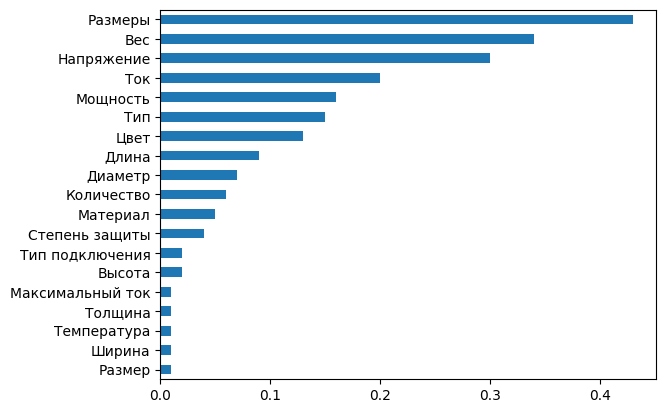

In [178]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

22.29.29.190


<Axes: >

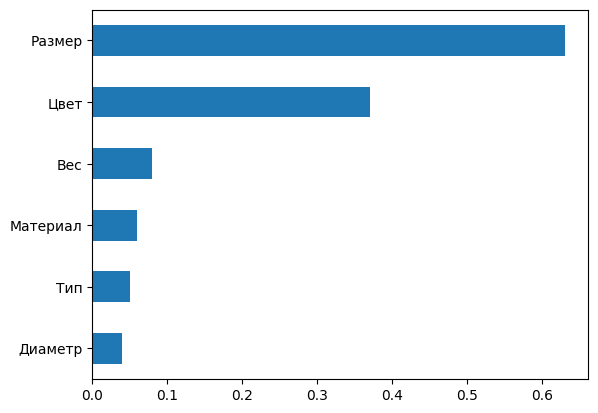

In [158]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

13.92.29.190


<Axes: >

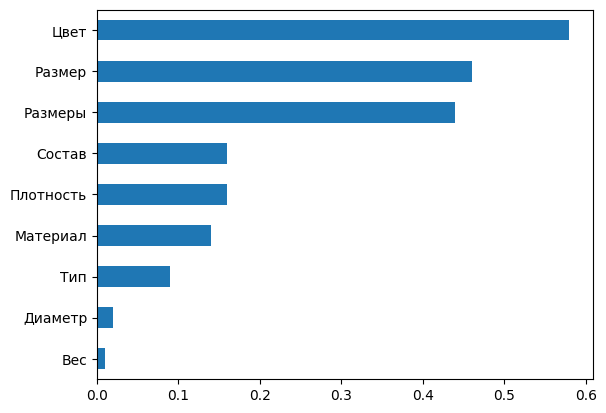

In [156]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

27.32.14.111


<Axes: >

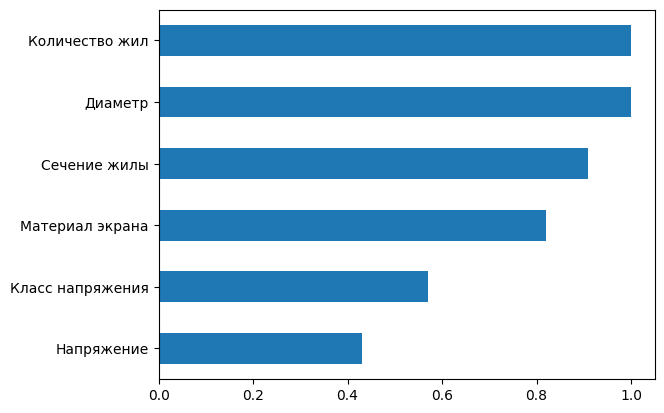

In [154]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

14.12.11.120


<Axes: >

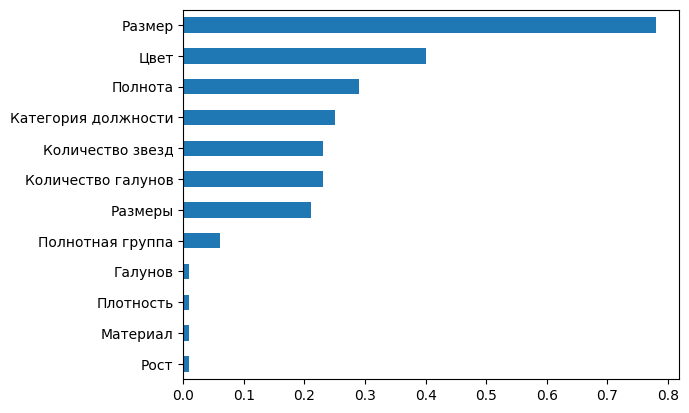

In [152]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

14.12.30.131


<Axes: >

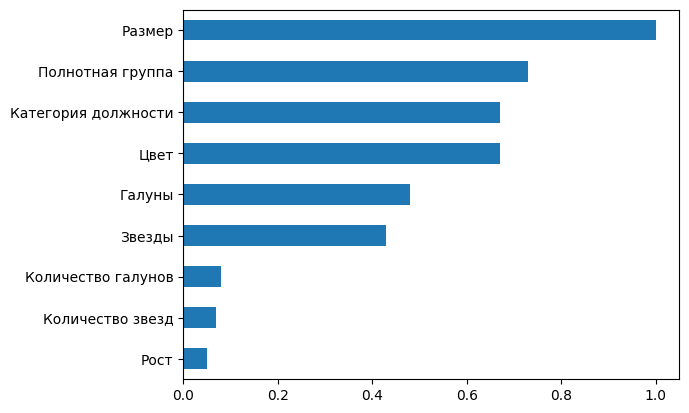

In [150]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

14.12.30.132


<Axes: >

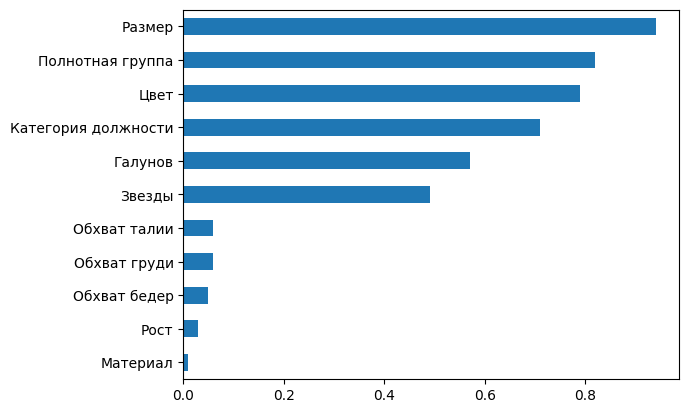

In [148]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

14.12.21.120


<Axes: >

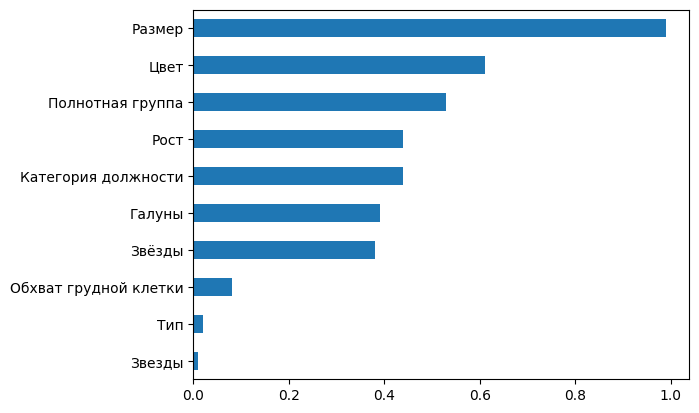

In [145]:
print(group_key)
(1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

In [263]:
df_group_1 = merged_df.iloc[:, :-313]
fltr = df_group_1.isna().sum() / df_group_1.shape[0] < 0.997

df_group_1 = df_group_1[df_group_1.columns[fltr]]
df_group_1.drop(columns=['id_y', 'index_y'], inplace=True)
# df_group_1.drop(columns=['id_y'], inplace=True)

tmp = ((1 - df_group_1.isna().sum() / df_group_1.shape[0]).round(3).iloc[14:].sort_values(ascending=True) * 1000).reset_index()

In [252]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

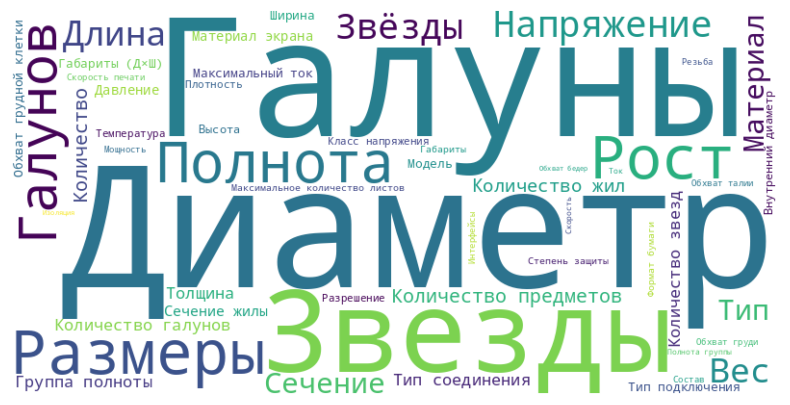

In [265]:
tmp = tmp.iloc[:-4]

word_freq = dict(zip(tmp['index'], tmp[0]))

# Создаем объект WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Отображаем облако слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключаем оси
plt.savefig('wordcloud.png')
plt.show()

# embed

In [179]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

(312,)


In [184]:
merged_df['name'].fillna('', inplace=True)
merged_df['mark_name'].fillna('', inplace=True)
merged_df['params'].fillna('', inplace=True)

In [187]:
def get_embed(x):
  embed = embed_bert_cls(x['name'] + ' ' + x['mark_name'] + ' ' + x['params'], model, tokenizer)
  return embed

merged_df['embed'] = merged_df.apply(lambda x: get_embed(x), axis=1)

In [188]:
tmp = pd.DataFrame(merged_df['embed'].tolist(), columns=[f'token_{i}' for i in range(312)])
merged_df = merged_df.join(tmp)
merged_df.drop('embed', axis=1, inplace=True)

In [193]:
columns = [col for col in merged_df.columns if col.startswith('token_')]

In [198]:
group_mean_vec = merged_df.groupby('okpd')[columns].mean()

In [207]:
def get_distance(x):
  okpd = x['okpd']
  vec = group_mean_vec[group_mean_vec.index == okpd].iloc[0]
  return cosine(x[columns], vec)

merged_df['distance'] = merged_df.apply(lambda x: get_distance(x), axis=1)

In [226]:
tmp = merged_df[merged_df['distance'] > 0.2].iloc[:, :-313]

# df_group_1 = tmp[tmp.okpd == group_key]
fltr = tmp.isna().sum() / tmp.shape[0] < 0.995

tmp = tmp[tmp.columns[fltr]]
tmp.drop(columns=['id_y', 'index_y'], inplace=True)

In [ ]:
(1 - tmp.isna().sum() / tmp.shape[0]).round(2).iloc[14:].sort_values(ascending=True).plot.barh()

In [273]:
merged_df.groupby('okpd')['distance'].agg(['count', 'std']).sort_values(by='count', ascending=False)

,count,std
okpd,,
14.12.21.120,2197,0.029510
14.12.30.132,1740,0.038798
14.12.30.131,1395,0.031288
14.12.11.120,852,0.027705
14.13.31.130,585,0.015663
27.33.13.130,582,0.031161
22.21.21.129,577,0.031396
27.33.13.190,572,0.028325
13.92.29.190,568,0.034260


<Axes: ylabel='okpd'>

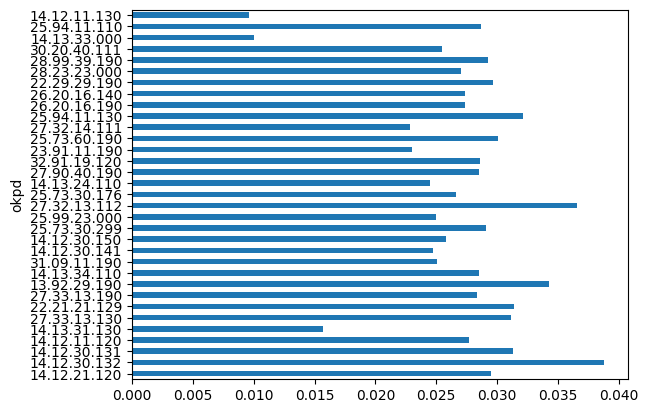

In [267]:
merged_df.groupby('okpd')['distance'].agg(['count', 'std']).sort_values(by='count', ascending=False)['std'].plot.barh()

In [ ]:
инсайт - наборы, характеристики в названии

In [230]:
tmp

,index_x,id_x,name,mark_name,gost,params,bei,okpd,OKPD2_NAME,okpd2_level_1,...,Длина,Резьба,Ширина,Сечение,Количество жил,Сечение жилы,Класс напряжения,Количество предметов,Тип соединения,Габариты (Д×Ш)
41,1752,3533000235,КАБЕЛЬ СИЛОВОЙ,ПВПНГ(А)2ГЖ-HF 1Х120/25-10,ТУ 27.32.14-007-47026389-2017,120 КВ.ММ 1ЖИЛА МК 10КВ,006,27.32.14.111,Кабели силовые с медной жилой на напряжение бо...,27,...,NaN,NaN,NaN,NaN,1,120 мм²,10 кВ,NaN,NaN,NaN
536,29265,2248200105,МУФТА,ПВХ,None,160,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,29267,2248200109,ТРОЙНИК,ПВХ,None,110Х110Х90,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,29268,2248200110,КОЛЕНО ПВХ,"УГ-87,5",None,110,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,29284,2248200119,УГОЛОК,ТК,None,26Х26,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,29287,2248200123,ТРУБА,ПВХ,ТУ 2243-010-10641390-01,D40 L=2000,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,29356,2248200304,КОЛЕНО,ПВХ,None,50Х45,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,29381,2248205003,ОТВОД ПВХ,,None,100 90 ГРАДУСОВ,796,22.21.21.129,Трубы полимерные жесткие прочие,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587,30709,2291390040,ПАНЕЛЬ,ПВХ,None,ДУБ,796,22.29.29.190,"Изделия пластмассовые прочие, не включенные в ...",22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091,107977,3449950048,ЗАЖИМ,DS 129456,None,19,796,27.90.40.190,"Оборудование электрическое прочее, не включенн...",27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Отвергнутые идеи

In [407]:
# ------------------------------------------------------------------------------------
# Хотели обработать все-все данные, несмотря на реальные возможности
# ------------------------------------------------------------------------------------
'''
Идея эаключалась в том, чтобы написать парсеры с использованием
контекстно свободной грамматики (tomita parser),
поработать очень по-прикладному с NLP - Natasha
Но это требует бОльших затрат по времени.
Плюс результат, которго мы достигаем с помощью такой обработки,
то есть выделения признаков из текста (NER), не нужен, если для этого
есть свобдное время, чтобы LLM спокойно обработала весь этот текст.
К тому же, можно улучшать уже написанные промпты, что может дать буст
в точности
'''


unique_keys = set()
for outer_dict in total_parsed_params:
    for inner_dict in outer_dict.values():
        if isinstance(inner_dict, dict):
            unique_keys.update(inner_dict.keys())

unique_keys_list = list(unique_keys)

print(unique_keys_list)

['Цвет', 'Категория должности', 'Галуны', 'Материал', 'Звезды', 'Полнота', 'Количество галунов', 'Размер']


In [ ]:
'''
Ниже псевдокод, идея которого - руками обработать группы, с поиском признаков,
которые выделила LLM. Например использовать NER для поиска цвета
'''

def get_features_group_1(row):
  print(row)

df[df['okpd'] == '14.12.30.132'].sample(20).params.apply(lambda x: get_features_group_1(x))

14.12.30.132
['Цвет', 'Категория должности', 'Галуны', 'Материал', 'Звезды', 'Полнота', 'Количество галунов', 'Размер']

# test 1

In [7]:
hf_key = os.environ.get("HF_API_TOKEN")
giga_key = os.environ.get("GIGACHAT_CREDENTIALS")
ai_key = os.environ.get("AI_TUNNEL_API")

In [55]:
giga = GigaChat(credentials=giga_key,
                model="GigaChat-Pro", timeout=100, verify_ssl_certs=False)
giga.verbose = False

In [9]:
llm = HuggingFaceHub(repo_id="gpt2", huggingfacehub_api_token=hf_key)

<ipython-input-9-222d41573004>:1: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  llm = HuggingFaceHub(repo_id="gpt2", huggingfacehub_api_token=hf_key) # govno


In [10]:
def get_prompt(user_content):
    messages = [
        SystemMessage(
            content="You have to separate technical specifications from a single line in JSON format"
        ),
        HumanMessage(content=user_content)
    ]
    return messages

In [11]:
query = '''
indicate the technical characteristics of the product in this line "630Х675Х4 СТ3СП 7,0КГ"
'''

prompt = get_prompt(query)
print(giga(prompt).content)

<ipython-input-11-2f76740a56ed>:6: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  print(giga(prompt).content)


The given line seems to be describing some kind of metal sheet or plate. Here's what we can deduce about its technical specifications:

1. Dimensions: 630mm x 675mm (width and length)
2. Thickness: 4 mm
3. Material: СТ3СП (assuming it's a type of steel)
4. Weight: 7.0 kg (approximate weight based on the dimensions and thickness)


In [66]:
from openai import OpenAI

client = OpenAI(
    api_key=ai_key,
    base_url="https://api.aitunnel.ru/v1/",
)

In [59]:
prompt = """
Примеры скоращений и полных названий - выше.

Тебе нужно разделить каждую характеристику продукта в формате JSON. Каждый продукт обладает своими характеристиками

Для каждого продукта приведите значения характеристик в формате JSON:

{
  'ID_1': {
    'Xарактеристика 1': 'Значение характеристики 1',
    'Xарактеристика 2': 'Значение характеристики 2',
    'Xарактеристика 3': 'Значение характеристики 3',
    ...
  },
  ...
}

Например:

{
  '1': {
        "Мощность двигателя": "4,3 кВт",
        "Обороты двигателя": "3600 об/мин",
        "Объем бака": "3,1 литр",
        "Размеры": "1800х650х900 мм",
        "Масса": "95 кг",
        "Крутящий момент": "0-1000 Нм"
    },
  '2': {
        'Объем бака': '1 литр',
        'Площадь обработки': '15 квадратных метров',
        'Расход топлива': '1,2 грамма на кубический сантиметр',
        'Диапазон крутящего момента': '4,5-5,5 Рн',
        'Мощность двигателя': '50 лошадиных сил'
    }
}

"1Л НА 15КВ.М 1.2Г/КУБ.СМ 4,5-5,5РН 5Л": "1 ЛИТР НА 15 КВАДРАТНЫХ МЕТРОВ, 1.2 ГРАММА НА КУБИЧЕСКИЙ САНТИМЕТР, 4,5-5,5 РН, 5 ЛИТРОВ"

### Продукты для анализа:
1. **Продукт**: РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА, Характеристики: "ПЛУНЖЕР ДГП005 2 ШТ, ГИЛЬЗА ДГП004 2 ШТ, МУФТА СМ4-08-18 1 ШТ, КОЛЬЦО Е 02-063 1 ШТ, КОЛЬЦО Е13-063 1 ШТ, КОЛЬЦО Е21-063 2 ШТ, МАНЖЕТА 20Х40-1 1 ШТ"
2. **Продукт**: ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ, Характеристики: "1Л НА 15КВ.М 1.2Г/КУБ.СМ 4,5-5,5РН 5Л"
3. **Продукт**: КРЫШКА ПЛАСТИКОВАЯ ДЛЯ ТОРТА ПРОЗРАЧНАЯ, Характеристики: "604Х384Х504 H=100 D=250 150 ШТ/УП БОПС"
4. **Продукт**: ПАПКА ПЛАСТИКОВАЯ С ФАЙЛАМИ, Характеристики: "А4 80ФАЙЛОВ ПРОЗРАЧНЫЙ"
5. **Продукт**: СТЕНД ИНФОРМАЦИОННЫЙ ПЛАСТИКОВЫЙ В АЛЮМИНИЕВОМ ПРОФИЛЕ, Характеристики: "1250Х1000Х4 9 ИНФОРМАЦИОННЫХ ПЛАКАТОВ А3"
6. **Продукт**: ПАПКА-ПОРТФЕЛЬ ПЛАСТИКОВЫЙ НА МОЛНИИ С ВЫДВИЖНЫМИ РУЧКАМИ, Характеристики: "9ОТДЕЛЕНИЙ 1КАРМАН 290Х355Х60 ЧЕРНЫЙ"
7. **Продукт**: ГАЙКОВЕРТ ПУТЕВОЙ С БЕНЗИНОВЫМ ДВИГАТЕЛЕМ, Характеристики: "0-1000НМ ДВИГАТЕЛЬ-4,3КВТ 3600ОБ/МИН БАК-3,1Л 1800Х650Х900 95КГ"

Пожалуйста, выполните сопоставление и предоставьте результат в формате JSON.
"""

In [64]:
system_prompt = """
Ваша задача — сопоставить сокращения физических характеристик продукта с их полными названиями. Если полное название не известно, определите его в зависимости от продукта.
"""

In [62]:
context = (ei['Наименование'].str[:] + ' = ' + ei['Краткое'].str[:]).str.cat(sep='\n')

In [67]:
completion = client.chat.completions.create(
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": context},
        {"role": "user", "content": prompt}
    ],
    max_tokens=10000,
    model="gpt-4o-mini"
)

print(completion.choices[0].message.content)

```json
{
    "РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА": {
        "ПЛУНЖЕР": "Плунжер",
        "ГИЛЬЗА": "Гильза",
        "МУФТА": "Муфта",
        "КОЛЬЦО": "Кольцо",
        "МАНЖЕТА": "Манжета",
        "ШТ": "Штук"
    },
    "ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ": {
        "Л": "Литр",
        "КВ.М": "Квадратный метр",
        "Г/КУБ.СМ": "


In [68]:
completion

ChatCompletion(id='gen-1728734633-BQqtRQrI7loEl4qCrZ5v', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='```json\n{\n    "РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА": {\n        "ПЛУНЖЕР": "Плунжер",\n        "ГИЛЬЗА": "Гильза",\n        "МУФТА": "Муфта",\n        "КОЛЬЦО": "Кольцо",\n        "МАНЖЕТА": "Манжета",\n        "ШТ": "Штук"\n    },\n    "ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ": {\n        "Л": "Литр",\n        "КВ.М": "Квадратный метр",\n        "Г/КУБ.СМ": "', refusal='', role='assistant', function_call=None, tool_calls=None))], created=1728734633, model='openai/gpt-4o-mini', object='chat.completion', service_tier=None, system_fingerprint='fp_e2bde53e6e', usage=CompletionUsage(completion_tokens=200, prompt_tokens=6985, total_tokens=7185, completion_tokens_details=None, prompt_tokens_details=None, cost_rub=0.21, balance=299.53000000000014))

In [53]:
len(text.split())

2238

In [12]:
text = (ei['Наименование'].str[:] + ' <-> ' + ei['Краткое'].str[:]).str.cat(sep='\n')

In [13]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.7 MB/s eta 0:00:00


In [40]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont


# Функция для сохранения текста в PDF
def save_text_to_pdf(text, file_name):
    # Создаем PDF документ
    pdf = canvas.Canvas(file_name, pagesize=A4)

    # Регистрируем шрифт, поддерживающий кириллицу
    pdfmetrics.registerFont(TTFont('DejaVuSans', 'DejaVuSans.ttf'))  # Убедитесь, что шрифт доступен

    # Устанавливаем шрифт
    pdf.setFont('DejaVuSans', 12)

    # Устанавливаем начальные координаты для текста
    width, height = A4
    margin = 50  # Отступы от краев
    y = height - margin  # Начальная высота для текста

    # Разбиваем текст по переносам строк (\n)
    lines = text.split('\n')

    for line in lines:
        # Проверка, поместится ли следующая строка
        if y < margin:  # Если не хватает места
            pdf.showPage()  # Создаем новую страницу
            pdf.setFont('DejaVuSans', 12)  # Устанавливаем шрифт заново
            y = height - margin  # Сброс высоты

        pdf.drawString(50, y, line)  # Параметры (x, y) для позиции текста
        y -= 15  # Уменьшаем y для перехода на следующую строку

    # Сохраняем PDF файл
    pdf.save()

# Сохраняем текст в PDF
save_text_to_pdf(text, "data/output.pdf")

# test llama index

In [15]:
!pip install -qU llama_index==0.9.40 pypdf==4.0.1 sentence_transformers==2.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.0 MB/s eta 0:00:00


In [16]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.llms import HuggingFaceLLM
from llama_index.prompts.prompts import SimpleInputPrompt

In [46]:
system_prompt="""
You are a Q&A assistant. Your goal is to answer questions as
accurately as possible based on the instructions and context provided.
"""

In [18]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index import ServiceContext
from llama_index.embeddings import LangchainEmbedding

embed_model=LangchainEmbedding(
    HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))

<ipython-input-18-ffac2e45ddeb>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [19]:
service_context = ServiceContext.from_defaults(
    chunk_size=1024,
    llm=giga,
    embed_model=embed_model
)

In [41]:
documents=SimpleDirectoryReader("data/").load_data()

In [42]:
index=VectorStoreIndex.from_documents(documents,service_context=service_context)

In [43]:
query_engine=index.as_query_engine()

In [ ]:
#######################

In [139]:
okpd_name = df[df.okpd == key]['OKPD2_NAME'].iloc[0]
df[df.okpd == key].sample(5)[['index', 'name', 'params']]

,index,name,params
302718,302718,КУРТКА МУЖСКАЯ ДЛЯ ЗАЩИТЫ ОТ ПОНИЖЕННЫХ ТЕМПЕР...,136-140 146-152
301655,301655,КУРТКА ПОВАРСКАЯ,104-158
563267,563267,КУРТКА МУЖСКАЯ ДЛЯ ЗАЩИТЫ ОТ ПОНИЖЕННЫХ ТЕМПЕР...,"104-108 158-164, 4 КЛАСС ЗАЩИТЫ, ТКАНЬ ВЕРХА-1..."
376104,376104,КУРТКА МУЖСКАЯ ДЛЯ ЗАЩИТЫ ОТ ПОНИЖЕННЫХ ТЕМПЕР...,АССОРТИ
302834,302834,КУРТКА-ПАРКА МУЖСКАЯ ЗИМНЯЯ С КАПЮШОНОМ И СВЕТ...,88-92 158-164 ПОЛИАМИД-84% ПОЛИАМИД-16% ТЕРРАК...


In [140]:
# <<<>>>,
user_input = system_prompt + """
Тебе нужно разделить каждую характеристику продукта в формате JSON. Каждый продукт обладает своими характеристиками
{
      'Характеристика 1': 'Значение характеристики 1',
      'Характеристика 2': 'Значение характеристики 2',
      'Характеристика 3': 'Значение характеристики 3'
}

Продукт: КУРТКА-ПАРКА МУЖСКАЯ ЗИМНЯЯ С КАПЮШОНОМ, Характеристики: "88-92 158-164 ПОЛИАМИД-84% ПОЛИАМИД-16%"
"""
start = time.time()
response = query_engine.query(user_input)
print(time.time() - start)
print(response.response)

7.473988056182861
Для данного продукта, куртки-парки мужской зимней с капюшоном, характеристики можно представить следующим образом:

{
    'Материал': 'полиамид',
    'Состав материала': '84% полиамид, 16% полиамид',
    'Размер': '88-92 см',
    'Рост': '158-164 см'
}


# trash

In [57]:
# <<<>>>,
user_input = system_prompt + """
Ваша задача — сопоставить сокращения физических характеристик продукта с их полными названиями. Если полное название не известно, определите его в зависимости от продукта.

Для каждого продукта приведите значения характеристик в формате JSON:

{
    'Продукт1': {
      'Сокращенная характеристика 1': 'Полное название характеристики 1',
      'Сокращенная характеристика 2': 'Полное название характеристики 2',
      'Сокращенная характеристика 3': 'Полное название характеристики 3',
      ...
    },
    ...
}

### Примеры сокращений и их полных названий:
- Л → Литр
- КВ.М → Квадратный метр
- ШТ → Штук
- СМ → Сантиметр
- С → Секунда
- Г → Грамм
- D → Диаметр

### Продукты для анализа:
1. **Продукт**: РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА, Характеристики: "ПЛУНЖЕР ДГП005 2 ШТ, ГИЛЬЗА ДГП004 2 ШТ, МУФТА СМ4-08-18 1 ШТ, КОЛЬЦО Е 02-063 1 ШТ, КОЛЬЦО Е13-063 1 ШТ, КОЛЬЦО Е21-063 2 ШТ, МАНЖЕТА 20Х40-1 1 ШТ"
2. **Продукт**: ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ, Характеристики: "1Л НА 15КВ.М 1.2Г/КУБ.СМ 4,5-5,5РН 5Л"
3. **Продукт**: КРЫШКА ПЛАСТИКОВАЯ ДЛЯ ТОРТА ПРОЗРАЧНАЯ, Характеристики: "604Х384Х504 H=100 D=250 150 ШТ/УП БОПС"
4. **Продукт**: ПАПКА ПЛАСТИКОВАЯ С ФАЙЛАМИ, Характеристики: "А4 80ФАЙЛОВ ПРОЗРАЧНЫЙ"

Пожалуйста, выполните сопоставление и предоставьте результат в формате JSON.
"""
start = time.time()
response = query_engine.query(user_input)
print(time.time() - start)
print(response.response)

29.15711545944214
{
    "РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА": {
        "ПЛУНЖЕР ДГП005 2 ШТ": "ПЛУНЖЕР ДГП005 - 2 ШТУКИ",
        "ГИЛЬЗА ДГП004 2 ШТ": "ГИЛЬЗА ДГП004 - 2 ШТУКИ",
        "МУФТА СМ4-08-18 1 ШТ": "МУФТА СМ4-08-18 - 1 ШТУКА",
        "КОЛЬЦО Е 02-063 1 ШТ": "КОЛЬЦО Е 02-063 - 1 ШТУКА",
        "КОЛЬЦО Е13-063 1 ШТ": "КОЛЬЦО Е13-063 - 1 ШТУКА",
        "КОЛЬЦО Е21-063 2 ШТ": "КОЛЬЦО Е21-063 - 2 ШТУКИ",
        "МАНЖЕТА 20Х40-1 1 ШТ": "МАНЖЕТА 20Х40-1 - 1 ШТУКА"
    },
    "ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ": {
        "1Л НА 15КВ.М 1.2Г/КУБ.СМ 4,5-5,5РН 5Л": "1 ЛИТР НА 15 КВАДРАТНЫХ МЕТРОВ, 1.2 ГРАММА НА КУБИЧЕСКИЙ САНТИМЕТР, 4,5-5,5 РН, 5 ЛИТРОВ"
    },
    "КРЫШКА ПЛАСТИКОВАЯ ДЛЯ ТОРТА ПРОЗРАЧНАЯ": {
        "604Х384Х504 H=100 D=250 150 ШТ/УП БОПС": "604 МИЛЛИМЕТРА Х 384 МИЛЛИМЕТРА Х 504 МИЛЛИМЕТРА, ВЫСОТА 100 МИЛЛИМЕТРОВ, ДИАМЕТР 250 МИЛЛИМЕТРОВ, 150 ШТУК В УПАКОВКЕ, МАТЕРИАЛ - БОПС"
    },
    "ПАПКА ПЛАСТИКОВАЯ С ФАЙЛАМИ"

In [56]:
# <<<>>>,
user_input = """
Ваша задача — сопоставить сокращения физических характеристик продукта с их полными названиями. Если полное название не известно, определите его в зависимости от продукта.

Для каждого продукта приведите значения характеристик в формате JSON:

{
    'Продукт1': {
      'Сокращенная характеристика 1': 'Полное название характеристики 1',
      'Сокращенная характеристика 2': 'Полное название характеристики 2',
      'Сокращенная характеристика 3': 'Полное название характеристики 3',
      ...
    },
    ...
}

### Примеры сокращений и их полных названий:
- Л → Литр
- КВ.М → Квадратный метр
- ШТ → Штук
- СМ → Сантиметр
- С → Секунда
- Г → Грамм
- D → Диаметр

### Продукты для анализа:
1. **Продукт**: РЕМКОМПЛЕКТ ПУТЕВОГО ГИДРАВЛИЧЕСКОГО ДОМКРАТА, Характеристики: "ПЛУНЖЕР ДГП005 2 ШТ, ГИЛЬЗА ДГП004 2 ШТ, МУФТА СМ4-08-18 1 ШТ, КОЛЬЦО Е 02-063 1 ШТ, КОЛЬЦО Е13-063 1 ШТ, КОЛЬЦО Е21-063 2 ШТ, МАНЖЕТА 20Х40-1 1 ШТ"
2. **Продукт**: ПОКРЫТИЕ ОТСЛАИВАЕМОЕ ЗАЩИТНОЕ ДЛЯ СТЕНОК ОКРАСОЧНО-СУШИЛЬНОЙ КАМЕРЫ, Характеристики: "1Л НА 15КВ.М 1.2Г/КУБ.СМ 4,5-5,5РН 5Л"
3. **Продукт**: КРЫШКА ПЛАСТИКОВАЯ ДЛЯ ТОРТА ПРОЗРАЧНАЯ, Характеристики: "604Х384Х504 H=100 D=250 150 ШТ/УП БОПС"
4. **Продукт**: ПАПКА ПЛАСТИКОВАЯ С ФАЙЛАМИ, Характеристики: "А4 80ФАЙЛОВ ПРОЗРАЧНЫЙ"
5. **Продукт**: СТЕНД ИНФОРМАЦИОННЫЙ ПЛАСТИКОВЫЙ В АЛЮМИНИЕВОМ ПРОФИЛЕ, Характеристики: "1250Х1000Х4 9 ИНФОРМАЦИОННЫХ ПЛАКАТОВ А3"
6. **Продукт**: ПАПКА-ПОРТФЕЛЬ ПЛАСТИКОВЫЙ НА МОЛНИИ С ВЫДВИЖНЫМИ РУЧКАМИ, Характеристики: "9ОТДЕЛЕНИЙ 1КАРМАН 290Х355Х60 ЧЕРНЫЙ"
7. **Продукт**: ГАЙКОВЕРТ ПУТЕВОЙ С БЕНЗИНОВЫМ ДВИГАТЕЛЕМ, Характеристики: "0-1000НМ ДВИГАТЕЛЬ-4,3КВТ 3600ОБ/МИН БАК-3,1Л 1800Х650Х900 95КГ"

Пожалуйста, выполните сопоставление и предоставьте результат в формате JSON.

"""
start = time.time()
response = query_engine.query(user_input)
print(time.time() - start)
print(response.response)

ReadTimeout: The read operation timed out